# ELE-32 - LAB 3 - LDPC (variante contínua)
---


# 1. Implemente um sistema que gera os valores LLR provenientes do canal quando transmitimos símbolos de uma modulação BPSK através de um canal Gaussiano
---

## Importações de bibliotecas
---

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numba import njit
import networkx as nx
from multiprocessing import Pool
import csv

## Definição dos parâmetros do ruído
---

In [2]:
@njit
def calcular_variancia_ruido(Eb_N0_dB: float) -> float:
    """
    Calcula a variância do ruído com base na relação sinal-ruído Eb/N0 em decibéis.

    Args:
        Eb_N0_dB (float): A relação sinal-ruído Eb/N0 em decibéis.

    Returns:
        float: A variância do ruído.

    """
    # Converter a relação sinal-ruído Eb/N0 de decibéis para linear
    Eb_N0 = 10**(Eb_N0_dB / 10)

    # Calcular a densidade espectral de potência do ruído
    N0 = 1 / Eb_N0

    # Calcular a variância do ruído
    sigma2 = N0 / 2

    return sigma2

In [3]:
# Exemplo de uso da função calcular_variancia_ruido
variancia_ruido = calcular_variancia_ruido(5)
print(f"Variância do ruído: {variancia_ruido}")

Variância do ruído: 0.15811388300841897


## Geração de símbolos aleatórios
---

In [4]:
@njit
def gerar_simbolos_bpsk(num_bits: int) -> np.ndarray:
    """
    Gera símbolos BPSK aleatórios.

    Parâmetros:
    - num_bits: O número de bits a serem gerados.

    Retorna:
    - Uma sequência de símbolos BPSK aleatórios, representados por -1 e 1.
    """
    return np.random.choice(np.array([-1, 1]), num_bits)

In [5]:
@njit 
def gerar_simbolos_bpsk_zero(num_bits: int) -> np.ndarray:
    """
    Gera símbolos BPSK com todos os bits iguais a zero.

    Parâmetros:
    - num_bits: O número de bits a serem gerados.

    Retorna:
    - Uma sequência de símbolos BPSK com todos os bits iguais a zero.
    """
    return np.full(num_bits, 1)

In [6]:
# Exemplo de uso da função gerar_simbolos_bpsk_zero
simbolos_bpsk = gerar_simbolos_bpsk_zero(10)
print(f"Símbolos BPSK gerados: {simbolos_bpsk}")

Símbolos BPSK gerados: [1 1 1 1 1 1 1 1 1 1]


## Cálculo de r
---

In [7]:
@njit
def calcular_valor_recebido(simbolos: np.ndarray, Eb_N0_dB: float) -> np.ndarray:
    """
    Calcula o valor recebido adicionando ruído gaussiano aos símbolos transmitidos.

    Parâmetros:
    simbolos (array): Array contendo os símbolos transmitidos.
    Eb_N0_dB (float): Relação sinal-ruído em dB.

    Retorna:
    array: Array contendo os símbolos recebidos após a adição de ruído gaussiano.
    """
    sigma2 = calcular_variancia_ruido(Eb_N0_dB)
    sigma = np.sqrt(sigma2)
    ruido = sigma * np.random.randn(len(simbolos))
    r = simbolos + ruido
    return r

In [8]:
# Exemplo de uso da função calcular_valor_recebido
valores_recebidos = calcular_valor_recebido(simbolos_bpsk, 0)
print(f"Valores recebidos: {valores_recebidos}")

Valores recebidos: [1.44615081 0.86734702 1.214614   0.82688832 1.86592802 1.06620665
 0.59011093 0.22936102 1.00103801 1.24192033]


## Cálculo de LLR
---

In [9]:
@njit
def calcular_valores_llr(r: np.ndarray, sigma2: float) -> np.ndarray:
    """
    Calcula os valores do Log-Likelihood Ratio (LLR) para uma sequência de bits recebida.

    Args:
        r (float): A sequência de bits recebida.
        sigma2 (float): A variância do ruído.

    Returns:
        float: Os valores do LLR para cada bit da sequência recebida.
    """
    llr = 2 * r / sigma2
    return llr

In [10]:
# Exemplo de uso da função calcular_valores_llr
Lc = calcular_valores_llr(valores_recebidos, variancia_ruido)
print(f"Valores LLR: {Lc}")

Valores LLR: [18.29252166 10.97116844 15.36378693 10.45940186 23.60233002 13.48656585
  7.46437851  2.90121286 12.66224049 15.70918762]


## Construção do LDPC (Lab 2)
---

### Definição de parâmetros

In [11]:
@njit
def set_params(N: int, dv: int, dc: int) -> tuple[int, int]:
    """
    Define os parâmetros do código LDPC.

    Args:
        N (int): O tamanho do código.
        dv (int): O grau do vetor de checagem.
        dc (int): O grau do vetor de informação.

    Returns:
        tuple[int, int]: Uma tupla contendo o tamanho da mensagem (K) e o tamanho do código (M).
    
    Raises:
        ValueError: Se N não for divisível por dc.
    """
    if (N  % dc != 0):
        raise ValueError("N must be divisible by dc")
    else:
        K = int(N / dc)
        M = int(K * dv)
        return (K, M)

In [12]:
# Exemplo de uso da função set_params
N = 10
dv = 3
dc = 5
K, M = set_params(N, dv, dc)
print(f"K: {K}; M: {M}")

K: 2; M: 6


### Geração da matriz LDPC

In [13]:
@njit
def generate_LDPC_matrix(N: int, dv: int, dc: int, K: int, M: int) -> np.ndarray:
    """
    Gera uma matriz LDPC de acordo com os parâmetros fornecidos.

    Parâmetros:
    - N (int): O número total de colunas da matriz.
    - dv (int): O grau do vértice variável.
    - dc (int): O grau do vértice de checagem.
    - K (int): O número de linhas da matriz antes da expansão.
    - M (int): O número de vezes que a matriz é expandida.

    Retorna:
    - H (ndarray): A matriz LDPC gerada.

    """
    H1 = np.zeros((K, N), dtype=np.int32)
    for i in range(len(H1)):
        H1[i][i * dc:(i + 1) * dc] = 1

    H = H1

    for _ in range(dv - 1):
        perm = np.random.permutation(N)
        H2 = H1[:, perm]
        H = np.concatenate((H, H2), axis=0)

    return H

In [41]:
def is_peg_matrix(matrix: np.ndarray) -> bool:
    """
    Checa se uma matriz é uma matriz PEG (Progressive Edge Growth).

    Parâmetros:
    - matrix (ndarray): A matriz a ser verificada.

    Retorna:
    - bool: True se a matriz é uma matriz PEG, False caso contrário.
    """
    # Check if the matrix is binary
    if not np.array_equal(matrix, matrix.astype(bool)):
        return False

    # Check if the matrix is sparse
    if np.count_nonzero(matrix) / matrix.size > 0.5:
        return False

    # Check if the matrix is regular
    row_counts = np.count_nonzero(matrix, axis=1)
    if np.any(row_counts != row_counts[0]):
        return False
    col_counts = np.count_nonzero(matrix, axis=0)
    if np.any(col_counts != col_counts[0]):
        return False

    return True

def generate_LDPC_matrix_PEG(N: int, dv: int, dc: int, K: int, M: int) -> np.ndarray:
    """
    Gera uma matriz LDPC usando o algoritmo PEG (Progressive Edge Growth).

    Parâmetros:
    - N (int): O número total de colunas da matriz.
    - dv (int): O grau do vértice variável.
    - dc (int): O grau do vértice de checagem.
    - K (int): O número de linhas da matriz antes da expansão.
    - M (int): O número de vezes que a matriz é expandida.

    Retorna:
    - H (ndarray): A matriz LDPC gerada.
    """
    H = np.zeros((M, N), dtype=np.int32)
    check_degrees = np.zeros(M, dtype=np.int32)
    symbol_degrees = np.zeros(N, dtype=np.int32)
    edges = []

    for j in range(N):
        for k in range(dv):
            if k == 0:
                min_degree = np.min(check_degrees)
                min_degree_indices = np.where(check_degrees == min_degree)[0]
                ci = np.random.choice(min_degree_indices)
                edges.append((ci, j))
                check_degrees[ci] += 1
                symbol_degrees[j] += 1
            else:
                tree = [j]
                for l in range(1, dc + 1):
                    next_level = []
                    for node in tree:
                        next_level.extend([edge[1] for edge in edges if edge[0] == node])
                    if len(next_level) == 0 or len(set(next_level)) < M:
                        break
                    tree = next_level

                # Exclude nodes that are already connected to j
                connected_nodes = [edge[0] for edge in edges if edge[1] == j]
                candidate_nodes = np.setdiff1d(np.arange(M), np.union1d(tree, connected_nodes))

                if len(candidate_nodes) == 0:
                    # If no candidate nodes are available, skip this edge
                    continue

                min_degree = np.min(check_degrees[candidate_nodes])
                min_degree_indices = np.where(check_degrees == min_degree)[0]
                ci = np.random.choice(min_degree_indices)
                edges.append((ci, j))
                check_degrees[ci] += 1
                symbol_degrees[j] += 1

    for edge in edges:
        H[edge[0], edge[1]] = 1

    if is_peg_matrix(H):
        return H
    else:
        return generate_LDPC_matrix_PEG(N, dv, dc, K, M)

In [15]:
# Exemplo de uso da função generate_LDPC_matrix
H = generate_LDPC_matrix(N, dv, dc, K, M)
print(f"Matriz LDPC gerada: \n{H}")

Matriz LDPC gerada: 
[[1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 1]
 [0 1 1 0 0 0 1 1 0 1]
 [1 0 0 1 1 1 0 0 1 0]
 [0 1 0 1 1 1 0 0 0 1]
 [1 0 1 0 0 0 1 1 1 0]]


In [16]:
H.shape

(6, 10)

In [17]:
H = generate_LDPC_matrix_PEG(N, dv, dc, K, M)
print(f"Matriz LDPC gerada: \n{H}"), is_peg_matrix(H)

Matriz LDPC gerada: 
[[0 1 1 0 0 1 1 0 0 1]
 [1 0 1 0 1 0 1 0 1 0]
 [0 1 0 1 1 0 1 0 0 1]
 [1 0 0 1 0 1 0 1 0 1]
 [0 1 1 0 0 1 0 1 1 0]
 [1 0 0 1 1 0 0 1 1 0]]


(None, True)

In [18]:
H.shape

(6, 10)

In [19]:
# Using the nx.Graph to visualize the bipartite graph from H matrix
def plot_bipartite_graph(H: np.array):
    G = nx.Graph()
    N, M = H.shape
    for i in range(N):
        for j in range(M):
            if H[i][j] == 1:
                G.add_edge(f'c{i}', f'v{j}')
    
    pos = {}
    for i in range(N):
        pos[f'c{i}'] = (i, 0)
    
    for i in range(M):
        pos[f'v{i}'] = (i, 1)
    
    nx.draw(G, pos, with_labels=True, node_size=500, font_size=10)
    plt.show()


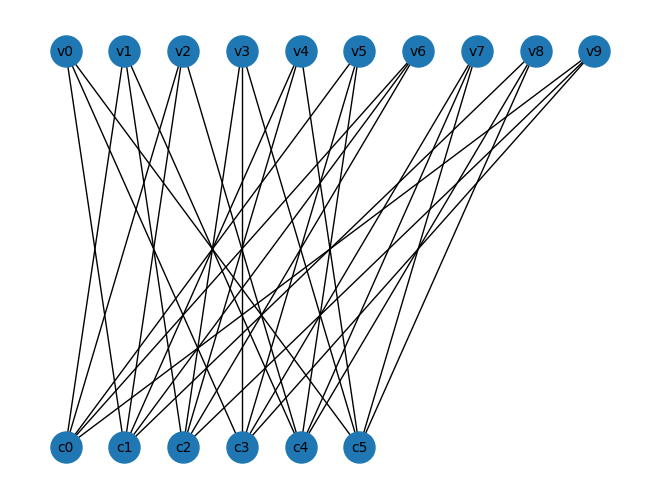

In [20]:
# Example
plot_bipartite_graph(H)

## Simulação da comunicação
---

In [21]:
@njit
def inicializar_mensagens(H: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Inicializa as mensagens dos c-nodes para os v-nodes e dos v-nodes para os c-nodes.

    Args:
        H (numpy.ndarray): Matriz de verificação de paridade (H).

    Returns:
        tuple: Uma tupla contendo as mensagens dos c-nodes para os v-nodes (Le) e as mensagens dos v-nodes para os c-nodes (Lr).
    """
    num_cnodes, num_vnodes = H.shape
    Le = np.zeros((num_cnodes, num_vnodes))  # Mensagens dos c-nodes para os v-nodes
    Lr = np.zeros((num_cnodes, num_vnodes))  # Mensagens dos v-nodes para os c-nodes
    return Le, Lr

In [22]:
# Exemplo de uso da função inicializar_mensagens
Le, Lr = inicializar_mensagens(H)
print(f"Mensagens Le iniciais: {Le}")
print(f"Mensagens Lr iniciais: {Lr}")

Mensagens Le iniciais: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Mensagens Lr iniciais: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [23]:
@njit
def atualizar_mensagens_vnodes(Lr: np.ndarray, Lc: np.ndarray, Le: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Atualiza as mensagens nos nós variáveis (v-nodes) de acordo com a matriz de paridade H.

    Parâmetros:
    - Lr: numpy.ndarray, matriz de mensagens nos nós de verificação (r-nodes)
    - Lc: numpy.ndarray, vetor de mensagens nos nós de checagem (c-nodes)
    - Le: numpy.ndarray, matriz de mensagens extrínsecas
    - H: numpy.ndarray, matriz de paridade

    Retorna:
    - Lr: numpy.ndarray, matriz de mensagens atualizadas nos nós de verificação (r-nodes)
    """
    num_cnodes, num_vnodes = H.shape
    for i in range(num_vnodes):
        for j in range(num_cnodes):
            if H[j, i] == 1:
                Lr[j, i] = Lc[i] + np.sum(Le[:, i]) - Le[j, i]
    return Lr

In [24]:
# Exemplo de uso da função atualizar_mensagens_vnodes
Lr = atualizar_mensagens_vnodes(Lr, Lc, Le, H)
print(f"Mensagens Lr atualizadas: {Lr}")

Mensagens Lr atualizadas: [[ 0.         10.97116844 15.36378693  0.          0.         13.48656585
   7.46437851  0.          0.         15.70918762]
 [18.29252166  0.         15.36378693  0.         23.60233002  0.
   7.46437851  0.         12.66224049  0.        ]
 [ 0.         10.97116844  0.         10.45940186 23.60233002  0.
   7.46437851  0.          0.         15.70918762]
 [18.29252166  0.          0.         10.45940186  0.         13.48656585
   0.          2.90121286  0.         15.70918762]
 [ 0.         10.97116844 15.36378693  0.          0.         13.48656585
   0.          2.90121286 12.66224049  0.        ]
 [18.29252166  0.          0.         10.45940186 23.60233002  0.
   0.          2.90121286 12.66224049  0.        ]]


In [25]:
@njit
def atualizar_mensagens_cnodes(Le: np.ndarray, Lr: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Atualiza as mensagens nos nós de verificação (cnodes) de acordo com a matriz de paridade H.

    Args:
        Le (numpy.ndarray): Array bidimensional que representa as mensagens de entrada nos cnodes.
        Lr (numpy.ndarray): Array bidimensional que representa as mensagens de entrada nos vnodes.
        H (numpy.ndarray): Matriz de paridade que define as conexões entre cnodes e vnodes.

    Returns:
        numpy.ndarray: Array bidimensional com as mensagens atualizadas nos cnodes.
    """
    num_cnodes, num_vnodes = H.shape
    for j in range(num_cnodes):
        for i in range(num_vnodes):
            if H[j, i] == 1:
                # Calcula o produto dos sinais
                product_sign = 1
                min_value = np.inf
                for k in range(num_vnodes):
                    if k != i and H[j, k] == 1:
                        product_sign *= np.sign(Lr[j, k])
                        min_value = min(min_value, abs(Lr[j, k]))
                # Calcula a mensagem de saída usando a equação 11
                Le[j, i] = product_sign * min_value
    return Le

In [26]:
# Exemplo de uso da função atualizar_mensagens_cnodes
Le = atualizar_mensagens_cnodes(Le, Lr, H)
print(f"Mensagens Le atualizadas: {Le}")

Mensagens Le atualizadas: [[ 0.          7.46437851  7.46437851  0.          0.          7.46437851
  10.97116844  0.          0.          7.46437851]
 [ 7.46437851  0.          7.46437851  0.          7.46437851  0.
  12.66224049  0.          7.46437851  0.        ]
 [ 0.          7.46437851  0.          7.46437851  7.46437851  0.
  10.45940186  0.          0.          7.46437851]
 [ 2.90121286  0.          0.          2.90121286  0.          2.90121286
   0.         10.45940186  0.          2.90121286]
 [ 0.          2.90121286  2.90121286  0.          0.          2.90121286
   0.         10.97116844  2.90121286  0.        ]
 [ 2.90121286  0.          0.          2.90121286  2.90121286  0.
   0.         10.45940186  2.90121286  0.        ]]


## Definindo a decisão
---

In [27]:
@njit
def iteracao(Lc: np.ndarray, Le: np.ndarray, Lr: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Realiza uma iteração do algoritmo de decodificação LDPC.

    Parâmetros:
    Lc (array): Array contendo as mensagens a priori dos c-nodes.
    Le (array): Array contendo as mensagens a priori dos v-nodes.
    Lr (array): Array contendo as mensagens dos v-nodes para os c-nodes.
    H (array): Matriz de verificação de paridade.

    Retorna:
    decision (array): Array contendo as decisões de bits após a iteração.
    """
    # Atualizar mensagens dos v-nodes
    Lr = atualizar_mensagens_vnodes(Lr, Lc, Le, H)
    
    # Atualizar mensagens dos c-nodes
    Le = atualizar_mensagens_cnodes(Le, Lr, H)
    
    # Critério de parada: verificar se todas as equações de paridade são satisfeitas
    decision = np.sign(Lc + np.sum(Le, axis=0))
    return decision

In [29]:
# Define a function for the parity check matrix
@njit
def syndrome_calc(H: np.array, x: np.array) -> np.array:
    """
    Calcula o vetor de síndrome de um código LDPC.

    Parâmetros:
    - H: A matriz de verificação de paridade.
    - x: O vetor de bits a ser verificado.

    Retorna:
    - Um vetor de síndrome.
    """
    s = np.zeros(H.shape[0], dtype = np.int32)

    for i in range(len(H)):
        s[i] = np.sum(H[i] * x) % 2
    
    return s

@njit
def parity_check(H: np.array, y: np.array) -> bool:
    """
    Verifica se um vetor y é um código válido de um código LDPC.

    Parâmetros:
    - H: A matriz de verificação de paridade.
    - y: O vetor de bits a ser verificado.

    Retorna:
    - Um valor booleano indicando se o vetor y é um código válido.
    """
    x = y.copy()
    for i in range(len(y)):
        if x[i] > 0:
            x[i] = 0
        else:
            x[i] = 1

    column_length = H.shape[1]
    errors = np.ones(column_length, dtype = np.int32)

    s = syndrome_calc(H, x)
    
    for i in range(column_length):
        errors[i] = np.sum(H[:, i] * s)

    if np.sum(errors) == 0:
        return True
    else:
        return False

In [30]:
# Exemplo de uso da função iteracao
n = 0
n += 1
decision = iteracao(Lc, Le, Lr, H)
print(f"Iteração n: {n}")
print(f"Mensagens Le atualizada: {Le}")
print(f"Mensagens Lr atualizada: {Lr}")
np.all(np.mod(np.dot(H, decision), 2) == 0)

Iteração n: 1
Mensagens Le atualizada: [[ 0.         19.28899157 19.28899157  0.          0.         21.33675981
  19.28899157  0.          0.         19.28899157]
 [18.46466622  0.         18.46466622  0.         18.46466622  0.
  18.46466622  0.         24.09494739  0.        ]
 [ 0.         16.26182759  0.         21.33675981 16.26182759  0.
  16.26182759  0.          0.         16.26182759]
 [20.82499323  0.          0.         23.85215721  0.         20.82499323
   0.         20.82499323  0.         20.82499323]
 [ 0.         23.02783186 23.02783186  0.          0.         23.02783186
   0.         23.02783186 23.82001658  0.        ]
 [20.82499323  0.          0.         23.02783186 20.82499323  0.
   0.         20.82499323 20.82499323  0.        ]]
Mensagens Lr atualizada: [[ 0.         21.33675981 25.7293783   0.          0.         19.28899157
  30.58602086  0.          0.         26.07477899]
 [24.09494739  0.         25.7293783   0.         33.96792139  0.
  28.89494881  0. 

False

In [31]:
decision

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [32]:
parity_check(H, decision)

True

# 2. Implemente o algoritmo de decodificação para códigos LDPC utilizando os valores LLR
---

In [42]:
@njit
def dot_product(H: np.ndarray, decision: np.ndarray) -> np.ndarray:
    """
    Calcula o produto escalar entre a matriz de verificação de paridade e as decisões de bits.

    Parâmetros:
    - H: A matriz de verificação de paridade.
    - decision: As decisões de bits.

    Retorna:
    - Um vetor de bits resultante do produto escalar.
    """
    result = np.zeros(H.shape[0], dtype=H.dtype)
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            result[i] += H[i, j] * decision[j]
    return result

@njit
def ldpc_decode(Lc: np.ndarray, Le: np.ndarray, Lr: np.ndarray, H: np.ndarray, max_iter: int = 100) -> np.ndarray:
    """
    Decodifica uma sequência de bits usando o algoritmo LDPC.

    Parâmetros:
    - Lc: array numpy de tamanho N, contendo as log-verossimilhanças dos bits recebidos.
    - H: array numpy de tamanho MxN, contendo a matriz de verificação de paridade LDPC.
    - max_iter: número máximo de iterações do algoritmo (padrão: 100).

    Retorna:
    - decoded_bits: array numpy de tamanho N, contendo os bits decodificados.

    """

    Le, Lr = inicializar_mensagens(H)
    n = 0

    for _ in range(max_iter):
        n += 1
        decision = iteracao(Lc, Le, Lr, H)
        if parity_check(H, decision):
            break
    
    # print(f"{n} iterações")
    # Decisão final
    Lf = Lc + np.sum(Le, axis=0)
    decoded_bits = np.sign(Lf).astype(np.int32)
    return decoded_bits

In [43]:
# Exemplo de uso da função ldpc_decode
H = generate_LDPC_matrix_PEG(N, dv, dc, K, M)
bits_decodificados = ldpc_decode(Lc, Le, Lr, H)
print(f"Bits gerados:       {simbolos_bpsk}")
print(f"Bits decodificados: {bits_decodificados}")
print(is_peg_matrix(H))


Bits gerados:       [1 1 1 1 1 1 1 1 1 1]
Bits decodificados: [1 1 1 1 1 1 1 1 1 1]
True


In [44]:
# Teste
# Define a function for the parity check matrix
@njit
def parity_check_test(H: np.array, y: np.array) -> np.array:
    s = np.zeros(H.shape[0], dtype = np.int32)

    for i in range(len(H)):
        s[i] = np.sum(H[i] * y) % 2
    
    return s

# Define a function for the bit-flipping algorithm to decode the message
@njit
def bit_flipping(H: np.array, y: np.array, max_iter: int) -> np.array:
    iteration = 0
    x = y.copy()
    column_length = H.shape[1]
    errors = np.ones(column_length, dtype = np.int32)

    s = parity_check_test(H, x)

    while np.sum(s) != 0 and iteration <= max_iter:
        for i in range(column_length):
            errors[i] = np.sum(H[:, i] * s)

        for i in range(len(errors)):
            if errors[i] == np.max(errors):
                x[i] ^= 1    

        s = parity_check_test(H, x)
        iteration += 1

    return x

In [45]:
test = bits_decodificados.copy()
for i in range(len(test)):
        if test[i] > 0:
            test[i] = 0
        else:
            test[i] = 1
res = bit_flipping(H, test, 100)

for i in range(len(res)):
    if res[i] == 0:
        res[i] = 1
    else:
        res[i] = -1

res


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

# 3. Utilize as duas implementações acima para estimar o desempenho do código  LDPC
---

## Cálculo do Bit Error Rate (BER)
---

In [46]:
@njit
def calcular_ber(bits_originais: np.ndarray, bits_decodificados: np.ndarray) -> float:
    """
    Calcula a taxa de erro de bit (BER - Bit Error Rate) entre os bits originais e os bits decodificados.

    Parâmetros:
    - bits_originais: array de bits originais
    - bits_decodificados: array de bits decodificados

    Retorna:
    - ber: a taxa de erro de bit (BER)

    Exemplo de uso:
    >>> bits_originais = [0, 1, 0, 1, 0]
    >>> bits_decodificados = [0, 1, 1, 1, 0]
    >>> calcular_ber(bits_originais, bits_decodificados)
    0.2
    """
    erros = np.count_nonzero(bits_originais != bits_decodificados)
    ber = erros / len(bits_originais)
    return ber

In [47]:
ber = calcular_ber(simbolos_bpsk, bits_decodificados)
print(f"Ber: {ber}")

Ber: 0.0


In [48]:
# Write ber in scientific notation
f"{ber:.2e}"

'0.00e+00'

## Simulação do desempenho do LDPC
---

### Método Sequencial

In [49]:
@njit
def mean_2d_axis1(arr):
    return np.sum(arr, axis=1) / arr.shape[1]

@njit
def simular_desempenho_ldpc(H: np.ndarray, num_bits: int, Eb_N0_dB_range: np.ndarray, num_of_iter: int = 50) -> np.ndarray:
    ber_results = np.zeros((Eb_N0_dB_range.size, num_of_iter))
    
    for i in range(Eb_N0_dB_range.size):
        for iter in range(num_of_iter):
            Eb_N0_dB = Eb_N0_dB_range[i]
            # Gerar símbolos BPSK
            simbolos = gerar_simbolos_bpsk_zero(num_bits).astype(np.float64)
            
            # Calcular valores recebidos com ruído
            r = calcular_valor_recebido(simbolos, Eb_N0_dB)
            
            # Calcular valores LLR
            sigma2 = calcular_variancia_ruido(Eb_N0_dB)
            Lc = calcular_valores_llr(r, sigma2)
            
            # Decodificar
            bits_decodificados = ldpc_decode(Lc, Le, Lr, H, max_iter = 10).astype(np.float64)
            
            # Calcular BER
            ber = calcular_ber(simbolos, bits_decodificados)
            ber_results[i][iter] = ber
        
    return mean_2d_axis1(ber_results)

In [50]:
a = simular_desempenho_ldpc(H, N, np.array([1]), num_of_iter=10_000)
print(f"{a[0]:.2e}")

1.67e-02


### Definição de Parâmetros para Simulação

In [51]:
# Definindo os parâmetros para simulação
num_bits = 1001
Eb_N0_dB_range = np.arange(0, 5.5, 0.5)

In [52]:
# Gerando a matriz LDPC
N = num_bits
dv = 3
dc = 7
K, M = set_params(N, dv, dc)
H = generate_LDPC_matrix_PEG(N, dv, dc, K, M)
is_peg_matrix(H)

True

In [105]:
def gerar_grafo_csv(H, filename='grafo_ldpc.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in H.T:
            indices = np.where(row == 1)[0]
            indices += 1
            writer.writerow(indices)

gerar_grafo_csv(H)

### Método Paralelizado

In [54]:
@njit
def simular_desempenho_ldpc_parallel(H: np.ndarray, num_bits: int, Eb_N0_dB: float, num_of_iter: int = 50) -> float:
    ber_results = np.zeros(num_of_iter)
    
    for iter in range(num_of_iter):
        # Gerar símbolos BPSK
        simbolos = gerar_simbolos_bpsk_zero(num_bits).astype(np.float64)
        
        # Calcular valores recebidos com ruído
        r = calcular_valor_recebido(simbolos, Eb_N0_dB)
        
        # Calcular valores LLR
        sigma2 = calcular_variancia_ruido(Eb_N0_dB)
        Lc = calcular_valores_llr(r, sigma2)
        
        # Decodificar
        bits_decodificados = ldpc_decode(Lc, Le, Lr, H, max_iter = 10).astype(np.float64)
        
        # Calcular BER
        ber = calcular_ber(simbolos, bits_decodificados)
        ber_results[iter] = ber
        
    return np.sum(ber_results) / ber_results.size

In [69]:
@njit
def simular_desempenho_ldpc_parallel_iter(H: np.ndarray, num_bits: int, Eb_N0_dB: float) -> float:
    # Gerar símbolos BPSK
    simbolos = gerar_simbolos_bpsk_zero(num_bits).astype(np.float64)
    
    # Calcular valores recebidos com ruído
    r = calcular_valor_recebido(simbolos, Eb_N0_dB)
    
    # Calcular valores LLR
    sigma2 = calcular_variancia_ruido(Eb_N0_dB)
    Lc = calcular_valores_llr(r, sigma2)
    
    # Decodificar
    bits_decodificados = ldpc_decode(Lc, Le, Lr, H, max_iter = 10).astype(np.float64)
        
    return np.count_nonzero(simbolos != bits_decodificados)

@njit
def ber_total(erros: np.ndarray, num_iter: int, num_bits: int) -> float:
    return np.sum(erros) / (num_iter * num_bits)

In [92]:
@njit
def worker(args):
    H, num_bits, Eb_N0_dB = args
    return simular_desempenho_ldpc_parallel_iter(H, num_bits, Eb_N0_dB)

if __name__ == "__main__":
    ber_list = []
    Eb_N0_dB = np.array([0, 0.5, 1])  # replace with your actual range
    num_iter =  (50_000, 50_000, 100_000)  # replace with your actual value

    # Create a Pool of processes
    with Pool() as p:
        # Map the function to the data
        for (Eb, num) in zip(Eb_N0_dB, num_iter):
            erros = np.array(list(filter(lambda x: x != 0, p.map(worker, [(H, num_bits, Eb) for _ in range(num)]))))
            ber = ber_total(erros, num, num_bits)
            ber_list.append(ber)

In [93]:
print(f"BER para Eb/N0 = 0: {ber_list[0]:.2e}")
print(f"BER para Eb/N0 = 0.5: {ber_list[1]:.2e}")
print(f"BER para Eb/N0 = 1: {ber_list[2]:.2e}")

BER para Eb/N0 = 0: 6.11e-03
BER para Eb/N0 = 0.5: 3.45e-04
BER para Eb/N0 = 1: 7.45e-06


- max_iter = 10:

    BER para Eb/N0 = 0.0: 6.11e-03

    BER para Eb/N0 = 0.5: 3.45e-04
    
    BER para Eb/N0 = 1.0: 7.45e-06

In [99]:
@njit
def worker(args):
    H, num_bits, Eb_N0_dB = args
    return simular_desempenho_ldpc_parallel_iter(H, num_bits, Eb_N0_dB)

if __name__ == "__main__":
    ber_list = []
    Eb_N0_dB = np.array([1.5])  # replace with your actual range
    num_iter =  200_000  # replace with your actual value

    # Create a Pool of processes
    with Pool() as p:
        # Map the function to the data
        erros = np.array(p.map(worker, [(H, num_bits, Eb_N0_dB) for _ in range(num_iter)]))
        ber = ber_total(erros, num_iter, num_bits)
        ber_list.append(ber)

In [100]:
print(f"BER para Eb/N0 = 1.5: {ber_list[0]:.2e}")

BER para Eb/N0 = 1.5: 7.69e-07


- max_iter = 10:

    BER para Eb/N0 = 1.5: 7.69e-07

In [101]:
@njit
def worker(args):
    H, num_bits, Eb_N0_dB = args
    return simular_desempenho_ldpc_parallel_iter(H, num_bits, Eb_N0_dB)

if __name__ == "__main__":
    ber_list = []
    Eb_N0_dB = np.array([2])  # replace with your actual range
    num_iter =  250_000  # replace with your actual value

    # Create a Pool of processes
    with Pool() as p:
        # Map the function to the data
        erros = np.array(list(filter(lambda x: x != 0, p.map(worker, [(H, num_bits, Eb_N0_dB) for _ in range(num_iter)]))))
        ber = ber_total(erros, num_iter, num_bits)
        ber_list.append(ber)

In [103]:
print(f"BER para Eb/N0 = 2.0: {ber_list[0]:.2e}")

BER para Eb/N0 = 2.0: 4.00e-08


- max_iter = 10:

    BER para Eb/N0 = 2.0: 4.00e-08

In [107]:
@njit
def worker(args):
    H, num_bits, Eb_N0_dB = args
    return simular_desempenho_ldpc_parallel_iter(H, num_bits, Eb_N0_dB)

if __name__ == "__main__":
    ber_list = []
    Eb_N0_dB = np.array([2.5])  # replace with your actual range
    num_iter =  300_000  # replace with your actual value

    # Create a Pool of processes
    with Pool() as p:
        # Map the function to the data
        erros = np.array(list(filter(lambda x: x != 0, p.map(worker, [(H, num_bits, Eb_N0_dB) for _ in range(num_iter)]))))
        ber = ber_total(erros, num_iter, num_bits)
        ber_list.append(ber)

In [108]:
print(f"BER para Eb/N0 = 2.5: {ber_list[0]:.2e}")

BER para Eb/N0 = 2.5: 6.66e-09


- max_iter = 10:

    BER para Eb/N0 = 2.5: 6.66e-09

In [113]:
@njit
def worker(args):
    H, num_bits, Eb_N0_dB = args
    return simular_desempenho_ldpc_parallel_iter(H, num_bits, Eb_N0_dB)

if __name__ == "__main__":
    ber_list = []
    Eb_N0_dB = np.array([3])  # replace with your actual range
    num_iter =  400_000  # replace with your actual value

    # Create a Pool of processes
    with Pool() as p:
        # Map the function to the data
        erros = np.array(list(filter(lambda x: x != 0, p.map(worker, [(H, num_bits, Eb_N0_dB) for _ in range(num_iter)]))))
        ber = ber_total(erros, num_iter, num_bits)
        ber_list.append(ber)

In [114]:
print(f"BER para Eb/N0 = 3.0: {ber_list[0]:.2e}")

BER para Eb/N0 = 3.0: 0.00e+00


- max_iter = 10:

    BER para Eb/N0 = 3.0: 0.00e+00

In [115]:
@njit
def worker(args):
    H, num_bits, Eb_N0_dB = args
    return simular_desempenho_ldpc_parallel_iter(H, num_bits, Eb_N0_dB)

if __name__ == "__main__":
    ber_list = []
    Eb_N0_dB = np.array([3.5])  # replace with your actual range
    num_iter =  450_000  # replace with your actual value

    # Create a Pool of processes
    with Pool() as p:
        # Map the function to the data
        erros = np.array(list(filter(lambda x: x != 0, p.map(worker, [(H, num_bits, Eb_N0_dB) for _ in range(num_iter)]))))
        ber = ber_total(erros, num_iter, num_bits)
        ber_list.append(ber)

In [116]:
print(f"BER para Eb/N0 = 3.5: {ber_list[0]:.2e}")

BER para Eb/N0 = 3.5: 0.00e+00


- max_iter = 10:

    BER para Eb/N0 = 3.5: 0.00e+00

### Cálculo do BER sem decodificação

In [118]:
@njit
def simular_desempenho_uncodified(num_bits: int, Eb_N0_dB: float) -> float:
    # Gerar símbolos BPSK
    simbolos = gerar_simbolos_bpsk_zero(num_bits).astype(np.float64)
    
    # Calcular valores recebidos com ruído
    r = calcular_valor_recebido(simbolos, Eb_N0_dB)
    
    # Decodificar
    bits_decodificados = np.sign(r).astype(np.float64)
        
    return np.count_nonzero(simbolos != bits_decodificados)

In [126]:
@njit
def worker(args):
    num_bits, Eb_N0_dB = args
    return simular_desempenho_uncodified(num_bits, Eb_N0_dB)

if __name__ == "__main__":
    ber_list = []
    Eb_N0_dB = np.array([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])  # replace with your actual range
    num_iter =  (1_000_000, 1_000_000, 1_000_000, 1_000_000, 1_000_000, 1_000_000, 
                 1_000_000, 1_000_000, 1_000_000, 1_000_000, 1_000_000)  # replace with your actual value

    # Create a Pool of processes
    with Pool() as p:
        # Map the function to the data
        for (Eb, num) in zip(Eb_N0_dB, num_iter):
            erros = np.array(list(filter(lambda x: x != 0, p.map(worker, [(num_bits, Eb) for _ in range(num)]))))
            ber = ber_total(erros, num, num_bits)
            ber_list.append(ber)

In [127]:
ber_list

[0.07865562437562437,
 0.06706601698301698,
 0.056279686313686315,
 0.04639899000999001,
 0.03750741058941059,
 0.029651912087912086,
 0.022884554445554445,
 0.017168641358641358,
 0.012499284715284715,
 0.008789496503496504,
 0.005950764235764236]

---
## Plot dos Resultados
---

In [128]:
ber_ldpc = [6.11e-03, 3.45e-04, 7.45e-06, 7.69e-07,
            4.00e-08, 6.66e-09, 0.00e+00, 0.00e+00,
            0.00e+00, 0.00e+00, 0.00e+00]

ber_uncodified = [0.07865562437562437, 0.06706601698301698,
                  0.056279686313686315, 0.04639899000999001,
                  0.03750741058941059, 0.029651912087912086,
                  0.022884554445554445, 0.017168641358641358,
                  0.012499284715284715, 0.008789496503496504,
                  0.005950764235764236]

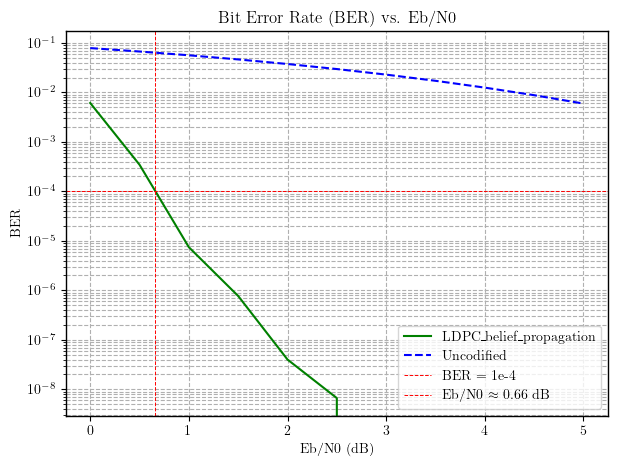

In [158]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(Eb_N0_dB_range, ber_ldpc, label="LDPC_belief_propagation", color='green')
ax.plot(Eb_N0_dB_range, ber_uncodified, label="Uncodified", color='blue', linestyle='dashed')
ax.grid(True, which="both", ls="--")
# Set xlims
#ax.set_xlim(5e-4, 0.11)
#ax.set_ylim(1e-7, 8e-1)
# ax.set_xscale('log')
# horizontal line in y = 10^-4
ax.axhline(y=1e-4, color='r', linestyle='--', label='BER = 1e-4', lw=0.7)
ax.axvline(x=0.6555, color='r', linestyle='--', label=r"Eb/N0 $\approx$ 0.66 dB", lw=0.7)
ax.set_yscale('log')
ax.legend(loc = 4)
ax.set_xlabel('Eb/N0 (dB)')
ax.set_ylabel('BER')
ax.set_title("Bit Error Rate (BER) vs. Eb/N0")
#plt.gca().invert_xaxis()
plt.savefig('error_rate_estimation3.pdf')
plt.show()

---
### Verificação sequencial (apenas para checagem)
---

In [130]:
ber_0db = ber_total(erros, num_iter, num_bits)
print(f"BER para Eb/N0 = 0 dB: {ber_0db:.2e}")
# ber_0db = 6.36e-03

BER para Eb/N0 = 0 dB: 6.36e-03


In [132]:
def worker(args):
    H, num_bits, Eb_N0_dB = args
    return simular_desempenho_ldpc_parallel_iter(H, num_bits, Eb_N0_dB)

if __name__ == "__main__":
    Eb_N0_dB = np.array([0.5])  # replace with your actual range
    num_iter = 20_000  # replace with your actual value

    # Create a Pool of processes
    with Pool() as p:
        # Map the function to the data
        erros = np.array(p.map(worker, [(H, num_bits, Eb_N0_dB) for _ in range(num_iter)]))

5 iterações
4 iterações
7 iterações9 iterações

5 iterações
6 iterações
5 iterações
6 iterações
7 iterações5 iterações6 iterações


3 iterações3 iterações
5 iterações
6 iterações

5 iterações
3 iterações6 iterações
6 iterações

5 iterações5 iterações5 iterações

5 iterações
6 iterações

7 iterações5 iterações
7 iterações5 iterações

9 iterações4 iterações

10 iterações7 iterações
7 iterações

6 iterações
6 iterações
6 iterações5 iterações
5 iterações
6 iterações
4 iterações
4 iterações
5 iterações5 iterações6 iterações


5 iterações

6 iterações
5 iterações

4 iterações4 iterações
5 iterações5 iterações
4 iterações10 iterações

6 iterações

5 iterações6 iterações


5 iterações9 iterações

5 iterações10 iterações
5 iterações6 iterações

8 iterações
4 iterações4 iterações7 iterações
5 iterações
8 iterações


6 iterações7 iterações5 iterações6 iterações



5 iterações4 iterações10 iterações8 iterações4 iterações3 iterações

6 iterações
6 iterações



10 iterações


5 iterações6 iterações


In [133]:
ber_05db = ber_total(erros, num_iter, num_bits)
print(f"BER para Eb/N0 = 0.5 dB: {ber_05db:.2e}")
# ber_05db = 3.60e-04

BER para Eb/N0 = 0.5 dB: 3.60e-04


In [136]:
def worker(args):
    H, num_bits, Eb_N0_dB = args
    return simular_desempenho_ldpc_parallel_iter(H, num_bits, Eb_N0_dB)

if __name__ == "__main__":
    Eb_N0_dB = np.array([1])  # replace with your actual range
    num_iter = 50_000  # replace with your actual value

    # Create a Pool of processes
    with Pool() as p:
        # Map the function to the data
        erros = np.array(p.map(worker, [(H, num_bits, Eb_N0_dB) for _ in range(num_iter)]))

4 iterações
4 iterações5 iterações
4 iterações6 iterações5 iterações



4 iterações
6 iterações5 iterações4 iterações3 iterações



4 iterações
5 iterações
4 iterações8 iterações

4 iterações4 iterações
3 iterações5 iterações4 iterações


4 iterações3 iterações5 iterações
5 iterações
4 iterações3 iterações


7 iterações


5 iterações4 iterações4 iterações

5 iterações

6 iterações3 iterações
4 iterações4 iterações
3 iterações
4 iterações3 iterações



5 iterações6 iterações
5 iterações
3 iterações3 iterações
5 iterações


3 iterações4 iterações6 iterações

5 iterações5 iterações
3 iterações6 iterações3 iterações

6 iterações6 iterações
3 iterações
2 iterações


5 iterações5 iterações


2 iterações

4 iterações
4 iterações3 iterações3 iterações
4 iterações2 iterações




4 iterações4 iterações3 iterações5 iterações
4 iterações

6 iterações

5 iterações
4 iterações6 iterações4 iterações

3 iterações5 iterações4 iterações

4 iterações


5 iterações5 iterações
6 iterações
3 iterações6 iter

In [139]:
ber_1db = ber_total(erros, num_iter, num_bits)
print(f"BER para Eb/N0 = 1 dB: {ber_1db:.2e}")
# ber_1db = 7.75e-06

BER para Eb/N0 = 1 dB: 7.75e-06


In [141]:
def worker(args):
    H, num_bits, Eb_N0_dB = args
    return simular_desempenho_ldpc_parallel_iter(H, num_bits, Eb_N0_dB)

if __name__ == "__main__":
    Eb_N0_dB = np.array([1.5])  # replace with your actual range
    num_iter = 100_000  # replace with your actual value

    # Create a Pool of processes
    with Pool() as p:
        # Map the function to the data
        erros = np.array(p.map(worker, [(H, num_bits, Eb_N0_dB) for _ in range(num_iter)]))

3 iterações
3 iterações3 iterações2 iterações

4 iterações
3 iterações4 iterações3 iterações2 iterações3 iterações





3 iterações3 iterações

2 iterações3 iterações4 iterações5 iterações

3 iterações
4 iterações

5 iterações
4 iterações5 iterações
3 iterações2 iterações
3 iterações
3 iterações
3 iterações



6 iterações2 iterações

4 iterações
3 iterações3 iterações4 iterações3 iterações

3 iterações
2 iterações3 iterações
2 iterações
3 iterações
3 iterações4 iterações



4 iterações3 iterações
3 iterações5 iterações

4 iterações
4 iterações


3 iterações
3 iterações
2 iterações2 iterações
2 iterações

2 iterações4 iterações3 iterações

4 iterações
5 iterações4 iterações


5 iterações3 iterações
4 iterações3 iterações

4 iterações5 iterações

2 iterações
3 iterações

3 iterações4 iterações
2 iterações
3 iterações
3 iterações4 iterações2 iterações4 iterações
4 iterações
3 iterações
3 iterações
3 iterações


3 iterações
4 iterações

3 iterações

2 iterações3 iterações

3 iterações
3 it

In [142]:
ber_15db = ber_total(erros, num_iter, num_bits)
print(f"BER para Eb/N0 = 1.5 dB: {ber_15db:.2e}")
# ber_15db = 9.99e-08

BER para Eb/N0 = 1.5 dB: 9.99e-08


In [81]:
def plotar_ber(Eb_N0_dB_range, ber_results):
    plt.figure(figsize=(10, 6))
    plt.plot(Eb_N0_dB_range, ber_results, marker='o', linestyle='-', color='b')
    plt.yscale('log')
    plt.xlabel('Eb/N0 (dB)')
    plt.ylabel('Taxa de Erro de Bit (BER)')
    plt.ylim([1e-16, 1])
    plt.title('Desempenho do Código LDPC')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

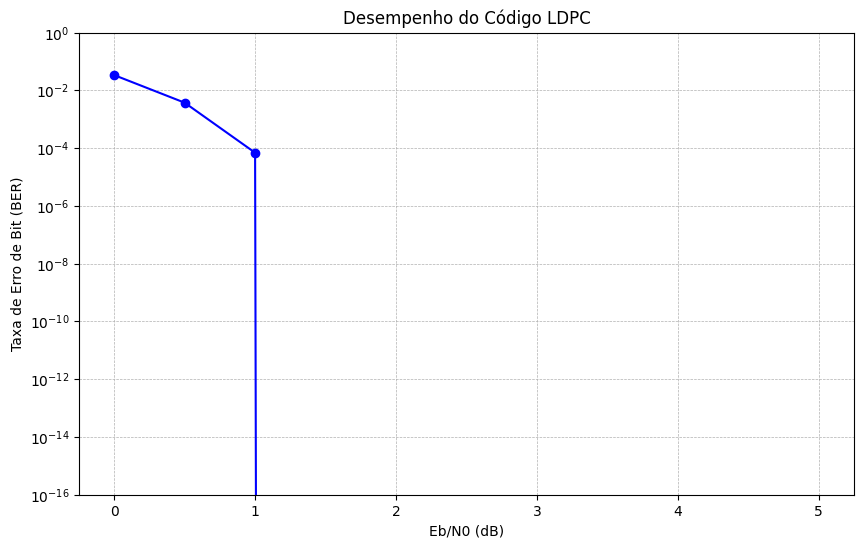

In [82]:
# Plotar o gráfico
plotar_ber(Eb_N0_dB_range, ber_results)

In [185]:
def encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range, threshold=1e-4):
    for Eb_N0_dB, ber in zip(Eb_N0_dB_range, ber_results):
        if ber < threshold:
            return Eb_N0_dB
    return None

# Encontrar o menor valor de Eb/N0 para BER < 10^-4
menor_eb_n0 = encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range)
print(f"Menor valor de Eb/N0 para BER < 10^-4: {menor_eb_n0} dB")

Menor valor de Eb/N0 para BER < 10^-4: None dB
